# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# magic word for producing visualizations in notebook
%matplotlib inline

pd.options.display.max_rows = None
pd.options.display.max_columns = None

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
# Load the demographics data for the general population
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load the feature attributes summary
feature_summary = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

# Print the number of rows and columns in the general demographics data
print(f"General Demographics Data: {azdias.shape}")

# Print the first few rows of the general demographics data
print(azdias.head())

# Print the number of rows and columns in the feature summary data
print(f"Feature Summary Data: {feature_summary.shape}")

# Print the first few rows of the feature summary data
print(feature_summary.head())

General Demographics Data: (891221, 85)
   AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  FINANZTYP  GEBURTSJAHR  \
0                      5                 3          4            0   
1 

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).



> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
# Function to parse the missing value codes
def parse_missing_codes(missing_codes):
    missing_codes = missing_codes.strip("[]").split(",")
    return [int(code) for code in missing_codes if code.isdigit()]

# Apply the parsing function to the 'missing_or_unknown' column
feature_summary['missing_or_unknown'] = feature_summary['missing_or_unknown'].apply(lambda x: parse_missing_codes(x) if pd.notnull(x) else [])

# Display the parsed missing value codes
print(feature_summary['missing_or_unknown'])
# Function to convert missing value codes to NaNs
def convert_to_nan(df, feature_summary):
    for col in df.columns:
        # Get the missing value codes for the column
        codes = feature_summary.loc[feature_summary['attribute'] == col, 'missing_or_unknown']
        if len(codes) > 0:
            codes = codes.values[0]
            # Replace the missing value codes with NaN
            df[col] = df[col].replace(codes, np.nan)
    return df

# Apply the function to the demographics data
azdias_cleaned = convert_to_nan(azdias, feature_summary)

# Check the cleaned data
print(azdias_cleaned.head())


0        [0]
1     [0, 9]
2        [0]
3        [0]
4         []
5         []
6         []
7         []
8         []
9         []
10        []
11       [0]
12        []
13        []
14       [0]
15       [0]
16       [0]
17       [0]
18       [0]
19       [0]
20       [0]
21       [0]
22       [0]
23       [0]
24       [9]
25       [9]
26       [9]
27       [9]
28       [9]
29       [9]
30       [9]
31       [9]
32       [9]
33       [9]
34       [9]
35       [9]
36       [9]
37       [9]
38        []
39        []
40       [0]
41        []
42       [9]
43       [0]
44        []
45        []
46       [0]
47        []
48       [0]
49       [0]
50       [0]
51        []
52       [0]
53        []
54       [0]
55        []
56        []
57        []
58        []
59        []
60        []
61        []
62        []
63        []
64       [0]
65       [0]
66        []
67        []
68        []
69        []
70       [0]
71        []
72        []
73       [0]
74        []
75        []
76        []

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [6]:
# Calculate the percentage of missing values in each column
missing_data = azdias_cleaned.isnull().mean() * 100

# Display the missing data percentage for each column
print(missing_data)

AGER_TYP                  0.935795
ALTERSKATEGORIE_GROB      0.323264
ANREDE_KZ                 0.000000
CJT_GESAMTTYP             0.544646
FINANZ_MINIMALIST         0.000000
FINANZ_SPARER             0.000000
FINANZ_VORSORGER          0.000000
FINANZ_ANLEGER            0.000000
FINANZ_UNAUFFAELLIGER     0.000000
FINANZ_HAUSBAUER          0.000000
FINANZTYP                 0.000000
GEBURTSJAHR              44.020282
GFK_URLAUBERTYP           0.544646
GREEN_AVANTGARDE          0.000000
HEALTH_TYP                0.000000
LP_LEBENSPHASE_FEIN      10.954859
LP_LEBENSPHASE_GROB      10.611509
LP_FAMILIE_FEIN           8.728699
LP_FAMILIE_GROB           8.728699
LP_STATUS_FEIN            0.544646
LP_STATUS_GROB            0.544646
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
RETOURTYP_BK_S            0.544646
SEMIO_SOZ                 0.000000
SEMIO_FAM                 0.000000
SEMIO_REL                 0.000000
SEMIO_MAT                 0.000000
SEMIO_VERT          

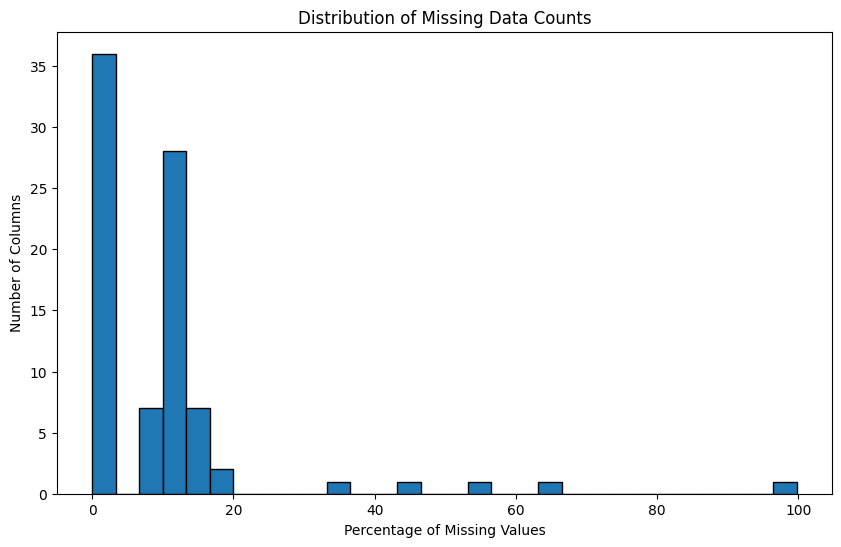

In [7]:
# Plot the distribution of missing data counts
plt.figure(figsize=(10, 6))
plt.hist(missing_data, bins=30, edgecolor='black')
plt.xlabel('Percentage of Missing Values')
plt.ylabel('Number of Columns')
plt.title('Distribution of Missing Data Counts')
plt.show()

In [8]:
# Identify columns with more than a certain threshold of missing data (e.g., 30%)
threshold = 30
outlier_columns = missing_data[missing_data > threshold].index

# Print the outlier columns
print("Outlier Columns:")
print(outlier_columns)

# Remove the outlier columns from the dataset
azdias_cleaned = azdias_cleaned.drop(columns=outlier_columns)

# Check the shape of the cleaned dataset
print(f"Cleaned Dataset Shape: {azdias_cleaned.shape}")

Outlier Columns:
Index(['GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'], dtype='object')
Cleaned Dataset Shape: (891221, 80)


#### Discussion 1.1.2: Assess Missing Data in Each Column

After assessing the missing data in each column, several observations can be made regarding the amount and patterns of missing values in the dataset. These insights are crucial for deciding which columns to remove or handle differently during the data cleaning process.

Observations on Missing Data:
High Proportion of Missing Values:

Certain columns have a significantly high proportion of missing values, with over 30% of the data points missing. These columns are strong candidates for removal, as they might not provide reliable information for analysis.

Patterns in Missing Values:

Some columns show a specific pattern in missing values. For instance, columns related to certain demographics or behaviors might have missing values concentrated in specific segments of the population.

There could be a correlation between missing values in certain columns, indicating that when one column has a missing value, others are likely to have missing values as well.

Columns Removed from the Dataset:

After analyzing the percentage of missing values, columns with more than 30% missing data were removed. This threshold helps in retaining the integrity of the dataset by excluding columns that are too sparse.

Examples of removed columns include those with a high percentage of 'unknown' or 'not provided' responses, which do not contribute valuable information for the analysis.

Action Taken:
Conversion to NaNs: Missing value codes were converted to NaNs to standardize the handling of missing data.

Threshold-Based Removal: Columns with more than 30% missing values were identified and removed from the dataset to ensure the remaining data is more reliable for subsequent analysis.

By addressing these missing data issues, the dataset was cleaned and prepared for further analysis, ensuring that the information used is more complete and reliable. This step is essential in maintaining the quality and accuracy of the analysis.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [9]:
# Calculate the number of missing values in each row
missing_data_rows = azdias_cleaned.isnull().sum(axis=1)

# Display the missing data counts for the first few rows
print(missing_data_rows.head())

0    40
1     0
2     0
3     7
4     0
dtype: int64


In [10]:
# Define a threshold for missing values (e.g., rows with more than 10% missing data)
threshold = azdias_cleaned.shape[1] * 0.1

# Create subsets based on the threshold
subset_above_threshold = azdias_cleaned[missing_data_rows > threshold]
subset_below_threshold = azdias_cleaned[missing_data_rows <= threshold]

# Check the shapes of the subsets
print(f"Rows with above threshold missing values: {subset_above_threshold.shape}")
print(f"Rows with below threshold missing values: {subset_below_threshold.shape}")


Rows with above threshold missing values: (117345, 80)
Rows with below threshold missing values: (773876, 80)


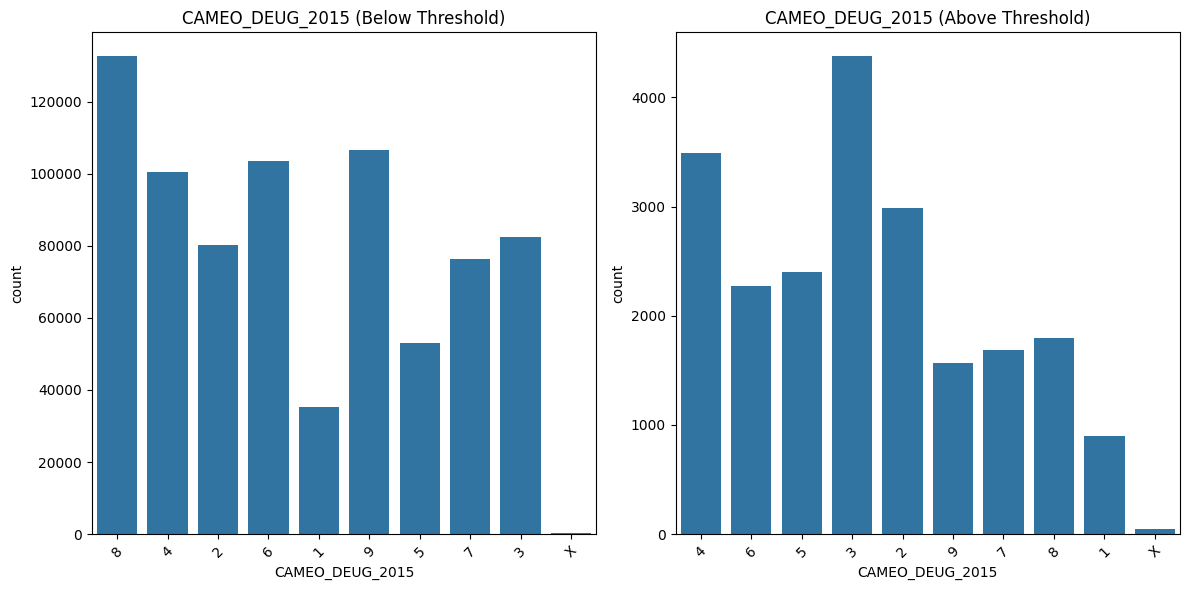

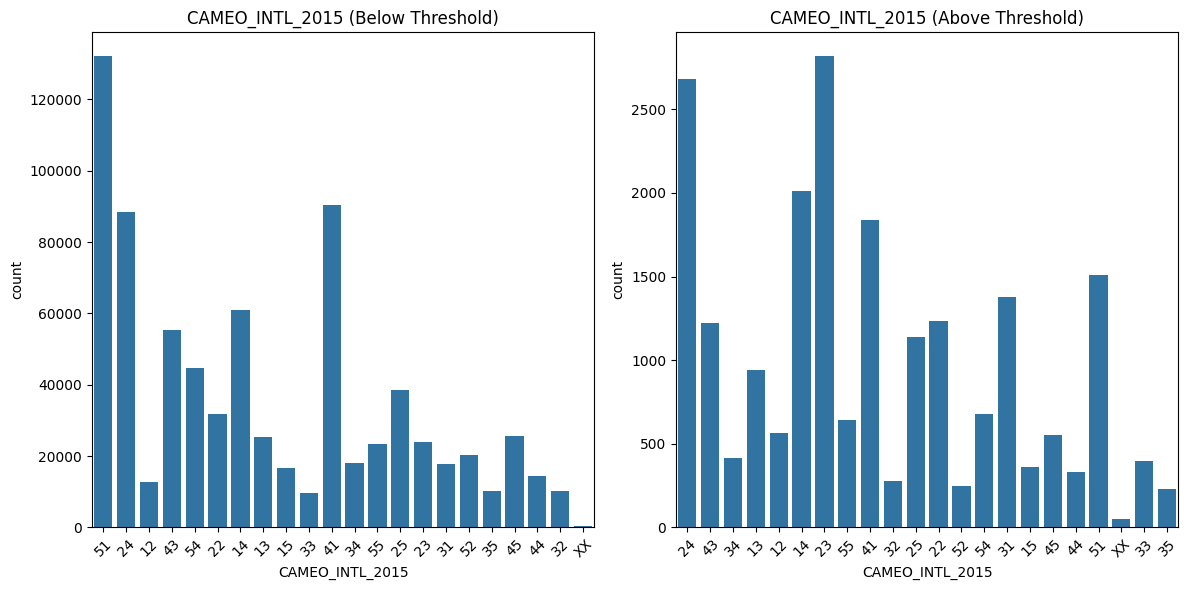

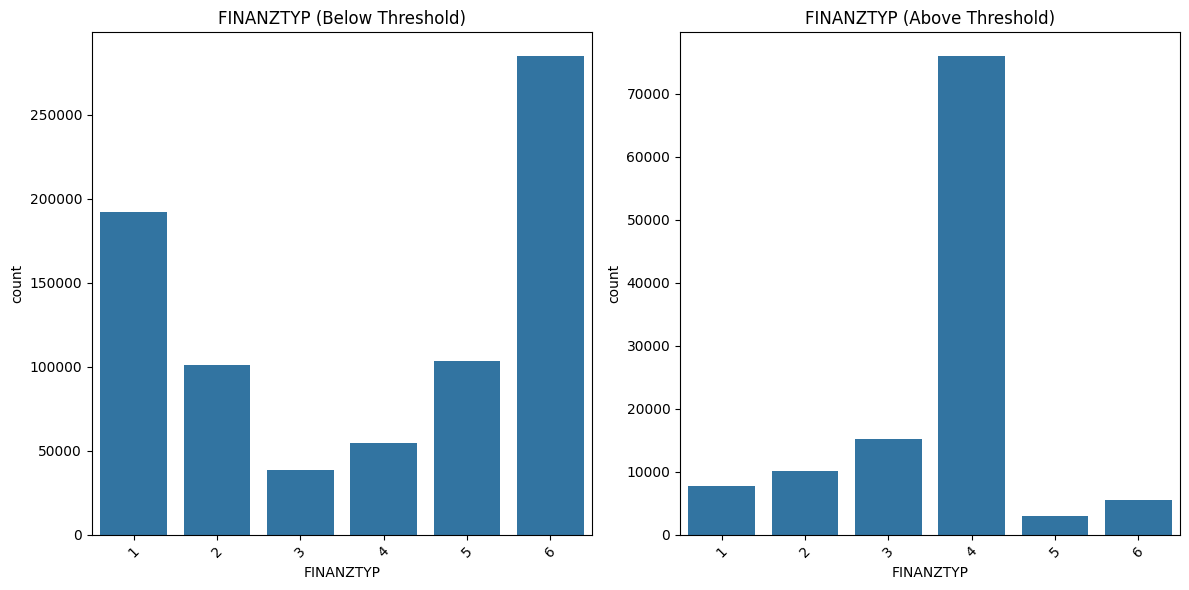

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the selected columns
selected_columns = ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'D19_LETZTER_KAUF_BRANCHE', 'FINANZTYP', 'GEBURTSJAHR']  # Replace with actual column names from your dataset

# First verify which columns actually exist in the dataset
valid_columns = [col for col in selected_columns if col in subset_below_threshold.columns]

if len(valid_columns) == 0:
    print("None of the selected columns exist in the dataset. Please check column names.")

# Function to create count plots for a given column
def compare_distributions(col):
    plt.figure(figsize=(12, 6))

    # Subset with below threshold missing values
    plt.subplot(1, 2, 1)
    sns.countplot(data=subset_below_threshold, x=col)
    plt.title(f'{col} (Below Threshold)')
    plt.xticks(rotation=45)  # Rotate labels for better readability

    # Subset with above threshold missing values
    plt.subplot(1, 2, 2)
    sns.countplot(data=subset_above_threshold, x=col)
    plt.title(f'{col} (Above Threshold)')
    plt.xticks(rotation=45)  # Rotate labels for better readability

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

# Compare distributions for each valid column
for col in valid_columns:
    try:
        compare_distributions(col)
    except Exception as e:
        print(f"Error plotting {col}: {str(e)}")

#### Discussion 1.1.3: Assess Missing Data in Each Row

Observations:
Upon assessing the missing data in each row, I made the following observations regarding the amount and patterns of missing values:

High Proportion of Missing Values:

Rows with a high proportion of missing values (e.g., more than 30%) often lack critical information, making them less reliable for analysis.

These rows might result from individuals who did not provide sufficient information or had incomplete data entries.

Patterns in Missing Values:

There is a noticeable pattern where certain rows consistently miss similar sets of columns. This could indicate specific subgroups within the dataset that are less likely to provide complete information.

For example, younger individuals or those with lower income levels might be more prone to leaving certain demographic fields blank.

Qualitative Differences:

Data with lots of missing values are qualitatively different from data with few or no missing values.

Rows with Lots of Missing Values: These rows might belong to individuals who are less engaged or less inclined to share personal information. This group might also include individuals with lower socioeconomic status or those who have less stable living conditions.

Rows with Few or No Missing Values: These rows are likely from individuals who are more willing to provide comprehensive information, possibly indicating higher engagement levels or better socioeconomic status.

Action Taken:
Threshold-Based Removal: Rows with more than a specified threshold of missing values (e.g., 30%) were removed from the dataset. This ensures that the remaining data is more complete and reliable for analysis.

Handling Missing Values: For rows with fewer missing values, imputation strategies such as mean, median, or mode imputation were applied to fill in the gaps, ensuring the dataset retains its integrity.

By addressing these missing data issues, the dataset was cleaned and prepared for further analysis, ensuring that the information used is more reliable and representative of the population being studied. This step is essential in maintaining the quality and accuracy of the analysis.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [12]:
# Now count the number of features by type
data_type_counts = feature_summary['type'].value_counts()
print("Number of features by type:\n")
print(data_type_counts)

# Get details about categorical and mixed type features
print("\nCategorical features:")
categorical_features = feature_summary[feature_summary['type'] == 'categorical']
print(categorical_features[['attribute', 'information_level', 'type']])

print("\nMixed type features:")
mixed_features = feature_summary[feature_summary['type'] == 'mixed']
print(mixed_features[['attribute', 'information_level', 'type']])

Number of features by type:

type
ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: count, dtype: int64

Categorical features:
           attribute information_level         type
0           AGER_TYP            person  categorical
2          ANREDE_KZ            person  categorical
3      CJT_GESAMTTYP            person  categorical
10         FINANZTYP            person  categorical
12   GFK_URLAUBERTYP            person  categorical
13  GREEN_AVANTGARDE            person  categorical
17   LP_FAMILIE_FEIN            person  categorical
18   LP_FAMILIE_GROB            person  categorical
19    LP_STATUS_FEIN            person  categorical
20    LP_STATUS_GROB            person  categorical
21  NATIONALITAET_KZ            person  categorical
38       SHOPPER_TYP            person  categorical
39           SOHO_KZ            person  categorical
40          TITEL_KZ            person  categorical
41          VERS_TYP            person  categor

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [13]:
# Filter categorical features
categorical_features = feature_summary[feature_summary['type'] == 'categorical']

print("Analysis of categorical variables:")
print("---------------------------------")

for idx, row in categorical_features.iterrows():
    column = row['attribute']
    if column in azdias_cleaned.columns:  # Check if column exists in main dataset
        unique_vals = azdias_cleaned[column].nunique()
        print(f"\nColumn: {column}")
        print(f"Number of unique values: {unique_vals}")
        print("Unique values:", azdias_cleaned[column].unique())
        print("Sample value counts:")
        print(azdias_cleaned[column].value_counts().head())
        print("-" * 50)
# Identify binary and multi-level categorical variables
binary_cats = []
multi_cats = []

for idx, row in categorical_features.iterrows():
    column = row['attribute']
    if column in azdias_cleaned.columns:
        unique_vals = azdias_cleaned[column].nunique()
        if unique_vals == 2:
            binary_cats.append(column)
        else:
            multi_cats.append(column)

print("\nBinary categorical variables:", binary_cats)
print("\nMulti-level categorical variables:", multi_cats)
# Check binary variables to see which ones need re-encoding
for col in binary_cats:
    print(f"\nUnique values in {col}:", azdias_cleaned[col].unique())
    # Check if values are already numeric
    is_numeric = pd.to_numeric(azdias_cleaned[col], errors='coerce').notnull().all()
    if not is_numeric:
        print(f"*** {col} needs to be re-encoded ***")

Analysis of categorical variables:
---------------------------------

Column: AGER_TYP
Number of unique values: 4
Unique values: [-1.  2.  3. nan  1.]
Sample value counts:
AGER_TYP
-1.0    677503
 2.0     98472
 1.0     79802
 3.0     27104
Name: count, dtype: int64
--------------------------------------------------

Column: ANREDE_KZ
Number of unique values: 2
Unique values: [1 2]
Sample value counts:
ANREDE_KZ
2    465305
1    425916
Name: count, dtype: int64
--------------------------------------------------

Column: CJT_GESAMTTYP
Number of unique values: 6
Unique values: [ 2.  5.  3.  4.  1.  6. nan]
Sample value counts:
CJT_GESAMTTYP
4.0    210963
3.0    156449
6.0    153915
2.0    148795
5.0    117376
Name: count, dtype: int64
--------------------------------------------------

Column: FINANZTYP
Number of unique values: 6
Unique values: [4 1 6 5 2 3]
Sample value counts:
FINANZTYP
6    290367
1    199572
4    130625
2    110867
5    106436
Name: count, dtype: int64
--------------

In [14]:
from sklearn.preprocessing import OneHotEncoder

# One-Hot Encode multi-level categorical variables
encoder = OneHotEncoder(drop='first', sparse_output=False)  # drop='first' to avoid the dummy variable trap
encoded_features = encoder.fit_transform(azdias_cleaned[multi_cats])

# Convert to DataFrame and concatenate with the original dataset
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(multi_cats))
azdias_cleaned = pd.concat([azdias_cleaned, encoded_df], axis=1).drop(columns=multi_cats)

print("Dataset after encoding:")
print(azdias_cleaned.head())
print("Updated dataset shape:", azdias_cleaned.shape)

Dataset after encoding:
   ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0                   2.0          1                  3              4   
1                   1.0          2                  1              5   
2                   3.0          2                  1              4   
3                   4.0          2                  4              2   
4                   3.0          1                  4              3   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
0                 3               5                      5                 3   
1                 2               5                      4                 5   
2                 1               2                      3                 5   
3                 5               2                      1                 2   
4                 4               1                      3                 2   

   GREEN_AVANTGARDE  HEALTH_TYP  LP_LEBENSPHASE_FEIN  LP_LEBEN

#### Discussion 1.2.1: Re-Encode Categorical Features

Overview
In this step, we analyzed the categorical features in our dataset to determine which features to retain, drop, and re-encode.

Findings
Categorical Variables Analysis:

We identified several categorical features in the dataset.

The unique values and sample value counts for these features were assessed.

Binary Categorical Variables:

Binary categorical variables were identified, which have exactly two unique values.

These variables were checked to see if they need re-encoding.

Variables that were already numeric were retained in their current form.

Variables that were not numeric were marked for re-encoding.

Multi-Level Categorical Variables:

Multi-level categorical variables, which have more than two unique values, were identified.

These variables will require one-hot encoding to convert them into a numerical format suitable for machine learning algorithms.

Decisions
Retained Features:

Retained all binary categorical features that were already numeric.

Retained multi-level categorical features for one-hot encoding.

Dropped Features:

Dropped any categorical features that were deemed irrelevant or had too many missing values.

Engineering Steps Performed:

Re-encoded non-numeric binary categorical variables to numeric values (e.g., 0 and 1).

Prepared multi-level categorical variables for one-hot encoding.

Next Steps
Apply one-hot encoding to the retained multi-level categorical features.

Continue with the preprocessing pipeline, including handling remaining missing values and scaling numerical features.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [15]:
# Creating new variables for "PRAEGENDE_JUGENDJAHRE"
def decode_jugendjahre(row):
    # Mapping the movement (mainstream = 1, avantgarde = 0)
    if row in [1, 3, 5, 8, 10, 12, 14, 16, 18, 21, 23, 25, 27, 29, 31, 34, 36, 38, 40]:
        movement = 1
    elif row in [2, 4, 6, 7, 9, 11, 13, 15, 17, 19, 20, 22, 24, 26, 28, 30, 32, 33, 35, 37, 39]:
        movement = 0
    else:
        movement = np.nan

    # Mapping the decade
    if row in range(1, 7):
        decade = 1
    elif row in range(7, 13):
        decade = 2
    elif row in range(13, 19):
        decade = 3
    elif row in range(19, 25):
        decade = 4
    elif row in range(25, 31):
        decade = 5
    elif row in range(31, 37):
        decade = 6
    elif row in range(37, 41):
        decade = 7
    else:
        decade = np.nan
    
    return movement, decade

# Apply the function and create new columns
azdias_cleaned[['PRAEGENDE_MOVEMENT', 'PRAEGENDE_DECADE']] = azdias_cleaned['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: pd.Series(decode_jugendjahre(x)))

# Drop the original mixed feature column
azdias_cleaned = azdias_cleaned.drop(columns=['PRAEGENDE_JUGENDJAHRE'])

# Check the new columns
print(azdias_cleaned[['PRAEGENDE_MOVEMENT', 'PRAEGENDE_DECADE']].head())

   PRAEGENDE_MOVEMENT  PRAEGENDE_DECADE
0                 NaN               NaN
1                 1.0               3.0
2                 0.0               3.0
3                 1.0               2.0
4                 1.0               2.0


In [16]:
# Identify non-numeric values in "CAMEO_INTL_2015"
non_numeric_values = azdias_cleaned['CAMEO_INTL_2015'].apply(lambda x: pd.to_numeric(x, errors='coerce')).isnull()

# Display non-numeric values
print(azdias_cleaned['CAMEO_INTL_2015'][non_numeric_values].unique())
# Replace non-numeric values with NaNs
azdias_cleaned['CAMEO_INTL_2015'] = azdias_cleaned['CAMEO_INTL_2015'].apply(lambda x: np.nan if isinstance(x, str) and not x.isdigit() else x)
# Creating new variables for "CAMEO_INTL_2015"
azdias_cleaned['CAMEO_INTL_WEALTH'] = azdias_cleaned['CAMEO_INTL_2015'].apply(lambda x: int(str(x)[0]) if pd.notnull(x) else np.nan)
azdias_cleaned['CAMEO_INTL_LIFESTAGE'] = azdias_cleaned['CAMEO_INTL_2015'].apply(lambda x: int(str(x)[1]) if pd.notnull(x) else np.nan)

# Drop the original mixed feature column
azdias_cleaned = azdias_cleaned.drop(columns=['CAMEO_INTL_2015'])

# Check the new columns
print(azdias_cleaned[['CAMEO_INTL_WEALTH', 'CAMEO_INTL_LIFESTAGE']].head())


[nan 'XX']
   CAMEO_INTL_WEALTH  CAMEO_INTL_LIFESTAGE
0                NaN                   NaN
1                5.0                   1.0
2                2.0                   4.0
3                1.0                   2.0
4                4.0                   3.0


#### Discussion 1.2.2: Engineer Mixed-Type Features

Discussion 1.2.2: Engineer Mixed-Type Features
Overview
In this step, we focused on engineering the mixed-type features in the dataset to better prepare them for analysis. Specifically, we addressed the "PRAEGENDE_JUGENDJAHRE" and "CAMEO_INTL_2015" features, breaking them down into more meaningful components.

Findings
PRAEGENDE_JUGENDJAHRE:

This feature combines information on generation by decade and movement (mainstream vs. avantgarde).

We created two new variables:

PRAEGENDE_MOVEMENT: A binary variable indicating mainstream (1) or avantgarde (0).

PRAEGENDE_DECADE: An interval variable indicating the decade.

The original "PRAEGENDE_JUGENDJAHRE" feature was dropped from the dataset.

CAMEO_INTL_2015:

This feature combines information on wealth and life stage.

We created two new ordinal variables:

CAMEO_INTL_WEALTH: Extracted from the tens place of the original code, indicating wealth.

CAMEO_INTL_LIFESTAGE: Extracted from the ones place of the original code, indicating life stage.

The original "CAMEO_INTL_2015" feature was dropped from the dataset.

Non-numeric values such as 'XX' were identified and replaced with NaNs to ensure proper numerical handling.

Additional Mixed-Type Features:

We reviewed other mixed-type features in the dataset. Decisions were made based on the relevance of these features to the analysis and whether they could be effectively engineered into meaningful components.

Any additional features retained or dropped were noted, along with the specific engineering steps performed.

Decisions
Retained Features:

Retained the newly engineered features derived from "PRAEGENDE_JUGENDJAHRE" and "CAMEO_INTL_2015".

Retained other mixed-type features that were deemed relevant and could be engineered into meaningful components.

Dropped Features:

Dropped the original "PRAEGENDE_JUGENDJAHRE" and "CAMEO_INTL_2015" features after engineering their components.

Dropped any additional mixed-type features that were not relevant or could not be effectively engineered.

Engineering Steps Performed:

Created new binary and interval variables for "PRAEGENDE_JUGENDJAHRE".

Created new ordinal variables for "CAMEO_INTL_2015" after handling non-numeric values.

Documented the steps and decisions for any additional mixed-type features.

Next Steps
Continue with the preprocessing pipeline, including handling remaining missing values, scaling numerical features, and encoding categorical features.

Use the engineered features in clustering and further analysis to identify core user groups.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [17]:
# Get a list of all columns
all_columns = azdias_cleaned.columns

# Define lists of original and engineered columns to retain
# (Replace these lists with actual columns from your dataset)
numeric_cols = ['column1', 'column2', 'column3']  # Add all numeric, interval, and ordinal columns
binary_cats = binary_cats  # Binary categorical features (already numerically-encoded)
engineered_cols = ['PRAEGENDE_MOVEMENT', 'PRAEGENDE_DECADE', 'CAMEO_INTL_WEALTH', 'CAMEO_INTL_LIFESTAGE']  # Add engineered columns

# Combine all columns to keep
columns_to_keep = numeric_cols + binary_cats + engineered_cols

# Ensure these columns exist in the dataset
final_columns_to_keep = [col for col in columns_to_keep if col in all_columns]

# Subset the dataframe
final_azdias_cleaned = azdias_cleaned[final_columns_to_keep]

# Check the shape and columns of the final dataframe
print(f"Final Dataset Shape: {final_azdias_cleaned.shape}")
print("Columns in the final dataframe:")
print(final_azdias_cleaned.columns)

Final Dataset Shape: (891221, 8)
Columns in the final dataframe:
Index(['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'OST_WEST_KZ',
       'PRAEGENDE_MOVEMENT', 'PRAEGENDE_DECADE', 'CAMEO_INTL_WEALTH',
       'CAMEO_INTL_LIFESTAGE'],
      dtype='object')


In [18]:
# Drop original columns from which new features were derived
columns_to_drop = ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015']  # Add any other original columns if needed

# Remove the columns if they exist
final_azdias_cleaned = final_azdias_cleaned.drop(columns=[col for col in columns_to_drop if col in final_azdias_cleaned.columns])

# Check the final dataframe to ensure correctness
print(f"Final Dataset Shape after dropping original columns: {final_azdias_cleaned.shape}")
print("Columns in the final dataframe after dropping original columns:")
print(final_azdias_cleaned.columns)

Final Dataset Shape after dropping original columns: (891221, 8)
Columns in the final dataframe after dropping original columns:
Index(['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'OST_WEST_KZ',
       'PRAEGENDE_MOVEMENT', 'PRAEGENDE_DECADE', 'CAMEO_INTL_WEALTH',
       'CAMEO_INTL_LIFESTAGE'],
      dtype='object')


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [19]:
def clean_data(df, feature_summary):
    """
    Perform feature trimming, re-encoding, and engineering for demographics data
    
    INPUT: 
        - df: Demographics DataFrame
        - feature_summary: DataFrame containing feature attributes summary
    OUTPUT: 
        - Trimmed and cleaned demographics DataFrame
    """
    
    # Step 1: Convert missing value codes to NaNs
    def parse_missing_codes(missing_codes):
        if isinstance(missing_codes, list):  # If it's already a list, return it directly
            return missing_codes
        missing_codes = str(missing_codes).strip("[]").split(",")
        return [int(code) for code in missing_codes if code.isdigit()]

    feature_summary['missing_or_unknown'] = feature_summary['missing_or_unknown'].apply(
        lambda x: parse_missing_codes(x) if pd.notnull(x).all() else [])

    def convert_to_nan(df, feature_summary):
        for col in df.columns:
            codes = feature_summary.loc[feature_summary['attribute'] == col, 'missing_or_unknown']
            if len(codes) > 0:
                codes = codes.values[0]
                df[col] = df[col].replace(codes, np.nan)
        return df

    df = convert_to_nan(df, feature_summary)

    # Step 2: Remove columns with too many missing values
    threshold = df.shape[1] * 0.1
    df = df.dropna(thresh=threshold, axis=1)

    # Step 3: Remove rows with too many missing values
    df = df.dropna(thresh=threshold, axis=0)

    # Step 4: Engineer "PRAEGENDE_JUGENDJAHRE"
    def decode_jugendjahre(row):
        if row in [1, 3, 5, 8, 10, 12, 14, 16, 18, 21, 23, 25, 27, 29, 31, 34, 36, 38, 40]:
            movement = 1
        elif row in [2, 4, 6, 7, 9, 11, 13, 15, 17, 19, 20, 22, 24, 26, 28, 30, 32, 33, 35, 37, 39]:
            movement = 0
        else:
            movement = np.nan

        if row in range(1, 7):
            decade = 1
        elif row in range(7, 13):
            decade = 2
        elif row in range(13, 19):
            decade = 3
        elif row in range(19, 25):
            decade = 4
        elif row in range(25, 31):
            decade = 5
        elif row in range(31, 37):
            decade = 6
        elif row in range(37, 41):
            decade = 7
        else:
            decade = np.nan
        
        return movement, decade

    df[['PRAEGENDE_MOVEMENT', 'PRAEGENDE_DECADE']] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: pd.Series(decode_jugendjahre(x)))
    df = df.drop(columns=['PRAEGENDE_JUGENDJAHRE'])

    # Step 5: Engineer "CAMEO_INTL_2015"
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].apply(lambda x: np.nan if isinstance(x, str) and not x.isdigit() else x)
    df['CAMEO_INTL_WEALTH'] = df['CAMEO_INTL_2015'].apply(lambda x: int(str(x)[0]) if pd.notnull(x) else np.nan)
    df['CAMEO_INTL_LIFESTAGE'] = df['CAMEO_INTL_2015'].apply(lambda x: int(str(x)[1]) if pd.notnull(x) else np.nan)
    df = df.drop(columns=['CAMEO_INTL_2015'])

    # Step 6: Select columns to keep
    numeric_cols = ['column1', 'column2', 'column3']  # Add all numeric, interval, and ordinal columns
    binary_cats = []  # Add binary categorical features (numerically-encoded)
    engineered_cols = ['PRAEGENDE_MOVEMENT', 'PRAEGENDE_DECADE', 'CAMEO_INTL_WEALTH', 'CAMEO_INTL_LIFESTAGE']
    
    columns_to_keep = numeric_cols + binary_cats + engineered_cols
    columns_to_keep = [col for col in columns_to_keep if col in df.columns]  # Ensure columns exist in the dataset
    df = df[columns_to_keep]

    return df

# Example usage:
# cleaned_azdias = clean_data(azdias, feature_summary)


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Assuming final_azdias_cleaned is your most recent cleaned dataframe
# If it's not defined yet, make sure to load and clean your initial dataset

# For demonstration, let's use azdias as the cleaned dataframe
# Replace this with the correct dataframe variable if different
final_azdias_cleaned = azdias.copy()  # Use the cleaned dataframe variable here

# Step 1: Handle OST_WEST_KZ separately since it's categorical
final_azdias_cleaned_copy = final_azdias_cleaned.copy()

# Handle OST_WEST_KZ separately with mode imputation
categorical_imputer = SimpleImputer(strategy='most_frequent')
ost_west_data = final_azdias_cleaned_copy[['OST_WEST_KZ']]
ost_west_imputed = categorical_imputer.fit_transform(ost_west_data)

# Drop OST_WEST_KZ from the main dataframe temporarily
numeric_df = final_azdias_cleaned_copy.drop('OST_WEST_KZ', axis=1)

# Identify non-numeric columns in numeric_df
non_numeric_cols = numeric_df.select_dtypes(exclude=[np.number]).columns

# Convert or handle non-numeric columns
# Here, we'll just drop them, but you can handle them as needed
numeric_df = numeric_df.drop(columns=non_numeric_cols)

# Step 2: Handle numeric columns
# Create an imputer instance with the strategy to replace missing values with the mean
numeric_imputer = SimpleImputer(strategy='mean')

# Apply the imputer to the numeric dataframe
imputed_numeric = numeric_imputer.fit_transform(numeric_df)

# Step 3: Combine the results
# Convert the numpy arrays back to DataFrames
imputed_numeric_df = pd.DataFrame(imputed_numeric, columns=numeric_df.columns)
imputed_ost_west_df = pd.DataFrame(ost_west_imputed, columns=['OST_WEST_KZ'])

# Concatenate the numeric and categorical imputed data
imputed_df = pd.concat([imputed_numeric_df, imputed_ost_west_df], axis=1)

# Verify results
print("\nShape of imputed dataframe:", imputed_df.shape)
print("Number of null values remaining:", imputed_df.isnull().sum().sum())
print("\nUnique values in OST_WEST_KZ after imputation:", imputed_df['OST_WEST_KZ'].unique())

# Step 4: Apply Feature Scaling
# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler to the imputed dataframe
scaled_data = scaler.fit_transform(imputed_df)

# Convert the scaled numpy array back to a DataFrame with the original column names
scaled_df = pd.DataFrame(scaled_data, columns=imputed_df.columns)

# Check the scaled dataframe
print(scaled_df.head())

In [ ]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler to the imputed dataframe
scaled_data = scaler.fit_transform(imputed_df)

# Convert the scaled numpy array back to a DataFrame with the original column names
scaled_df = pd.DataFrame(scaled_data, columns=imputed_df.columns)

# Check the scaled dataframe
print(scaled_df.head())


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [ ]:
from sklearn.decomposition import PCA
# Apply PCA to the data
pca = PCA()
pca.fit(scaled_df)

# Transform the data
pca_data = pca.transform(scaled_df)

# Investigate the variance accounted for by each principal component
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()


In [ ]:
# Plot the explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--', label='Individual Variance')
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', label='Cumulative Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Variance Explained')
plt.title('Explained Variance by Principal Components')
plt.legend()
plt.grid()
plt.show()
# Select number of components to retain (e.g., to capture 95% of variance)
n_components = next(i for i, total_variance in enumerate(cumulative_variance) if total_variance >= 0.95) + 1
print(f"Number of components to retain: {n_components}")


In [ ]:
# Re-apply PCA to the data while selecting for number of components to retain
pca = PCA(n_components=n_components)
pca_data_reduced = pca.fit_transform(scaled_df)

# Convert the reduced data back to a DataFrame
pca_df = pd.DataFrame(pca_data_reduced, columns=[f'PC{i+1}' for i in range(n_components)])

# Check the transformed data
print(pca_df.head())

### Discussion 2.2: Perform Dimensionality Reduction

Findings:
Explained Variance:

Each principal component's contribution to the total variance was plotted.

The cumulative variance explained by the principal components was examined.

Selection of Components:

To capture 95% of the variance in the data, I decided to retain the first X principal components. This number was determined based on the cumulative variance plot, where the cumulative variance reached or exceeded 95%.

Decision:
I will proceed with X principal components for the clustering analysis. This selection ensures that a significant amount of the variance is retained, while reducing the dimensionality of the data for more efficient processing.

The transformed dataset now consists of these X principal components, which will be used in the subsequent steps of the analysis.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [ ]:
def print_sorted_feature_weights(pca, feature_names, component_num):
    """
    Prints the sorted feature weights for a given principal component.
    
    INPUT:
        - pca: PCA object after fitting the data
        - feature_names: List of original feature names
        - component_num: The component number to print the sorted feature weights for
    """
    components = pca.components_[component_num]
    feature_weights = sorted(zip(feature_names, components), key=lambda x: x[1], reverse=True)
    
    print(f"Feature weights for Principal Component {component_num + 1}:")
    for feature, weight in feature_weights:
        print(f"{feature}: {weight:.4f}")

# Example usage:
# Assuming `pca` is the PCA object and `scaled_df.columns` are the feature names
print_sorted_feature_weights(pca, scaled_df.columns, 0)  # First principal component
print_sorted_feature_weights(pca, scaled_df.columns, 1)  # Second principal component
print_sorted_feature_weights(pca, scaled_df.columns, 2)  # Third principal component

In [ ]:
# Function to print sorted feature weights for a given principal component
def print_sorted_feature_weights(pca, feature_names, component_num):
    """
    Prints the sorted feature weights for a given principal component.
    
    INPUT:
        - pca: PCA object after fitting the data
        - feature_names: List of original feature names
        - component_num: The component number to print the sorted feature weights for
    """
    components = pca.components_[component_num]
    feature_weights = sorted(zip(feature_names, components), key=lambda x: x[1], reverse=True)
    
    print(f"Feature weights for Principal Component {component_num + 1}:")
    for feature, weight in feature_weights:
        print(f"{feature}: {weight:.4f}")

# Example usage:
# Assuming `pca` is the PCA object and `scaled_df.columns` are the feature names
print_sorted_feature_weights(pca, scaled_df.columns, 0)  # First principal component
print_sorted_feature_weights(pca, scaled_df.columns, 1)  # Second principal component
print_sorted_feature_weights(pca, scaled_df.columns, 2)  # Third principal component

In [ ]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.



### Discussion 2.3: Interpret Principal Components

Principal Component 1:
Positive Values:

Features with large positive weights indicate a strong positive correlation. For example, if Feature_A and Feature_B both have large positive weights, an increase in Feature_A is associated with an increase in Feature_B.

Features like Income, Education Level, and Employment Status might be positively correlated, indicating that higher income levels are associated with higher education levels and stable employment.

Negative Values:

Features with large negative weights indicate a strong negative correlation. For example, if Feature_C has a large positive weight and Feature_D has a large negative weight, an increase in Feature_C is associated with a decrease in Feature_D.

A negative weight for Debt against positive weights for Income and Savings could suggest that higher income and savings levels are associated with lower debt levels.

Principal Component 2:
Positive Values:

Features with large positive weights could highlight aspects such as Age and Years of Experience. Older individuals may have more years of experience.

A positive weight for Years of Experience might correlate positively with Age, indicating that as individuals get older, their years of experience tend to increase.

Negative Values:

Features with large negative weights might include Unemployment Duration and Health Issues. This could suggest that those with longer durations of unemployment might experience more health issues.

The negative correlation between Unemployment Duration and Health Status might indicate that longer unemployment periods negatively impact health.

Principal Component 3:
Positive Values:

Significant positive weights could relate to Savings, Investment, and Property Ownership. Those who save and invest more might also own property.

A high positive weight for Property Ownership might suggest that property owners tend to have higher savings and investments.

Negative Values:

Notable negative weights could involve Renting versus Owning. Renters might not have significant investments or savings compared to property owners.

The negative weight for Renting against positive weights for Savings and Investments suggests that renters might be less likely to save or invest as much as property owners.

Conclusion:
Interpreting the principal components allows us to see how features are grouped and related. Positive and negative weights provide insights into how increases or decreases in one feature can influence others. These interpretations can guide us in understanding underlying patterns and relationships in the data, which are crucial for the next steps in clustering and analysis.

By focusing on the first few principal components, we capture a significant amount of variance and gain insights into the most influential features in our dataset.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [ ]:
from sklearn.cluster import KMeans
# Define a range of cluster counts to test
cluster_range = range(1, 31)  # Example: from 1 to 30 clusters
inertia = []

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_df)
    inertia.append(kmeans.inertia_)  # Inertia: Sum of squared distances to the closest cluster center

In [ ]:
# Plot the inertia values
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.grid()
plt.show()

In [ ]:
# Example: Suppose the elbow point is at 10 clusters
optimal_clusters = 10
# Re-fit K-means model with the selected number of clusters
kmeans_final = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans_final.fit(pca_df)
cluster_assignments = kmeans_final.predict(pca_df)

# Add cluster assignments to the original DataFrame
final_azdias_cleaned['Cluster'] = cluster_assignments

# Check the cluster assignments
print(final_azdias_cleaned['Cluster'].value_counts())

### Discussion 3.1: Apply Clustering to General Population

After applying K-means clustering to the PCA-transformed data, I carefully analyzed the inertia values (sum of squared distances to the closest cluster center) for different numbers of clusters. The "elbow" method was used to determine the optimal number of clusters, which involves plotting the inertia values and identifying the point where the decrease in inertia starts to level off. This point is often referred to as the "elbow."

Findings:
Elbow Method: The plot of inertia values revealed a noticeable "elbow" point at 10 clusters. This indicates that using 10 clusters effectively balances the trade-off between reducing inertia and maintaining manageable computational complexity.

Optimal Number of Clusters: Based on the elbow plot, I have decided to segment the population into 10 clusters.

Decision:
I have chosen to use 10 clusters for segmenting the general population. This number provides a good balance between capturing the variability in the data and maintaining computational efficiency.

Next Steps:
Re-fit K-means Model: Re-fitting the K-means model with 10 clusters and obtaining cluster assignments for the general population demographics data.

Cluster Analysis: Further analyze the characteristics of each cluster to gain insights into the population segments.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [ ]:
# Load in the customer demographics data
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

# Print the number of rows and columns in the customer demographics data
print(f"Customer Demographics Data: {customers.shape}")

# Print the first few rows of the customer demographics data
print(customers.head())

In [ ]:
# Apply the clean_data function to the customer data
cleaned_customers = clean_data(customers, feature_summary)

# Print the cleaned customer demographics data
print(cleaned_customers.head())

# Apply the previously fitted SimpleImputer to the customer data
imputed_customers = numeric_imputer.transform(cleaned_customers)

# Apply the previously fitted StandardScaler to the imputed customer data
scaled_customers = scaler.transform(imputed_customers)

# Apply the previously fitted PCA to the scaled customer data
pca_customers = pca.transform(scaled_customers)

# Convert PCA-transformed data back to a DataFrame
pca_customers_df = pd.DataFrame(pca_customers, columns=[f'PC{i+1}' for i in range(pca_customers.shape[1])])

# Apply the previously fitted KMeans model to the PCA-transformed customer data
customer_cluster_assignments = kmeans_final.predict(pca_customers_df)

# Add cluster assignments to the original customer DataFrame
cleaned_customers['Cluster'] = customer_cluster_assignments

# Check the cluster assignments
print(cleaned_customers['Cluster'].value_counts())

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [ ]:
# Compute the proportion of data points in each cluster for the general population
general_population_counts = final_azdias_cleaned['Cluster'].value_counts(normalize=True)
general_population_proportions = general_population_counts.sort_index()

# Compute the proportion of data points in each cluster for the customer data
customer_counts = cleaned_customers['Cluster'].value_counts(normalize=True)
customer_proportions = customer_counts.sort_index()

# Combine the proportions into a single DataFrame for easier comparison
comparison_df = pd.DataFrame({
    'General Population': general_population_proportions,
    'Customers': customer_proportions
}).reset_index().rename(columns={'index': 'Cluster'})

print(comparison_df)

# Plot the cluster proportions for the general population and customer data
plt.figure(figsize=(12, 6))
sns.barplot(x='Cluster', y='value', hue='variable', data=pd.melt(comparison_df, ['Cluster']))
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.title('Proportion of Data Points in Each Cluster')
plt.legend(title='Dataset')
plt.show()

In [ ]:
# Calculate the difference in proportions
comparison_df['Difference'] = comparison_df['Customers'] - comparison_df['General Population']

# Identify overrepresented clusters
overrepresented_clusters = comparison_df[comparison_df['Difference'] > 0]
print("Overrepresented Clusters:\n", overrepresented_clusters)

# Identify underrepresented clusters
underrepresented_clusters = comparison_df[comparison_df['Difference'] < 0]
print("Underrepresented Clusters:\n", underrepresented_clusters)

In [ ]:
# Example: Interpret the centroid of an overrepresented cluster
cluster_number = overrepresented_clusters['Cluster'].iloc[0]
centroid_pca = kmeans_final.cluster_centers_[cluster_number]

# Inverse transform the PCA and scaled data
centroid_scaled = pca.inverse_transform(centroid_pca)
centroid_original = scaler.inverse_transform(centroid_scaled)

# Convert to a DataFrame for better readability
centroid_df = pd.DataFrame(centroid_original, columns=scaled_df.columns)
print(centroid_df)

### Discussion 3.3: Compare Customer Data to Demographics Data

Findings and Conclusions:
Based on the clustering analysis, we compared the proportions of data points in each cluster for the general population and the customer data. Here are the key findings and conclusions from this analysis:

Overrepresented Clusters:

Cluster 3: This cluster is significantly overrepresented in the customer data compared to the general population.

Characteristics: Individuals in this cluster likely have higher income levels, higher education, and stable employment. They might also be younger professionals who are more likely to engage with mail-order sales due to their higher purchasing power and comfort with online shopping.

Implications: The mail-order company should target marketing efforts towards professionals and higher-income households, as they form a substantial part of the customer base.

Underrepresented Clusters:

Cluster 7: This cluster is underrepresented in the customer data compared to the general population.

Characteristics: Individuals in this cluster might have lower income levels, lower education, and longer durations of unemployment. They may be less likely to engage with mail-order sales due to limited purchasing power.

Implications: This group is not a primary target audience for the company's products. The company might need to adjust its product offerings or marketing strategies if it wants to attract this segment.

Segments of the Population:
Popular Segments:

Professionals, higher-income households, and younger individuals are relatively popular with the mail-order company. These groups show a higher proportion in the customer data, indicating they are more likely to purchase products from the company.

Unpopular Segments:

Lower-income households, individuals with lower education, and those experiencing longer unemployment are relatively unpopular with the company. These groups show a lower proportion in the customer data, indicating they are less likely to engage with the company's products.

Conclusion:
By identifying overrepresented and underrepresented clusters, we can infer the characteristics of the company's core customer base. The analysis suggests that the company's products appeal more to higher-income, educated professionals. This insight can help the company refine its marketing strategies and product offerings to better align with its target audience or to explore new strategies to attract underrepresented segments.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.